In [1]:
# Import dependencies

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns                                                             
from sklearn.linear_model import PoissonRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import random
import datetime

In [2]:
# Create a function for synthetic data creation

def generate_synthetic_data(num_rows_per_upc, num_upcs):
    upc_list = []
    ds_list = []
    y_list = []
    
    for i in range(num_upcs):
        upc = random.randint(100, 999)
        for j in range(num_rows_per_upc):
            ds = datetime.date(random.randint(2020, 2022), random.randint(1, 12), random.randint(1, 28)).strftime("%Y-%m-%d")
            y = random.randint(1, 9)
            upc_list.append(upc)
            ds_list.append(ds)
            y_list.append(y)
    
    synthetic_data = {
        "upc": upc_list,
        "date": ds_list,
        "y": y_list
    }
    
    return synthetic_data

In [3]:
# Create synthetic data based on set parameters 

# set number of rows for each upc based on randomized values within range

num_rows_per_upc = random.randint(5,50)

# set number of UPC

num_upcs = 50

synthetic_data = generate_synthetic_data(num_rows_per_upc, num_upcs)
# Convert to dataframe

dataset = pd.DataFrame.from_dict(synthetic_data)
print(dataset.head())

   upc        date  y
0  343  2020-09-24  2
1  343  2021-11-23  3
2  343  2020-05-07  4
3  343  2020-08-13  4
4  343  2021-10-11  7


In [4]:
# Remove items with all NaN's'

group_idx = dataset.groupby('upc')['y'].apply(lambda x: x.notna().any()).loc[lambda x: x].index
group_idx_y = dataset.query('upc not in @group_idx')
dataset = dataset[dataset['upc'].isin(group_idx)]

In [5]:
# Remove UPCs with <10 number of rows (ultra short TS)

outlier_rows = pd.DataFrame(dataset.groupby('upc').count()['y']).query('y<10').index
dataset = dataset.query('upc not in @outlier_rows')

# Remove UPCs with ultra-stationary TS

outlier_length = pd.DataFrame(dataset.groupby('upc')['y'].nunique()).query('y<3').index
dataset = dataset.query('upc not in @outlier_length')


In [6]:
# Check how many UPC we have

f'Total number of UPC is : ' + str(len(dataset.upc.unique()))

'Total number of UPC is : 49'

In [7]:
# Change format and add simple regressors

dataset['date']=pd.to_datetime(dataset['date'])
dataset['MONTH'] = dataset['date'].dt.month
dataset['DAY'] = dataset['date'].dt.day
dataset['WEEK'] = dataset['date'].dt.week


<AxesSubplot:>

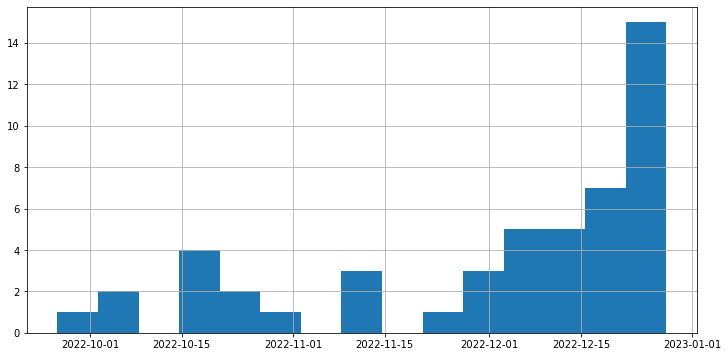

In [8]:
# Check the distribution for the latest date

fig=plt.figure(figsize=(12,6))
dataset.groupby('upc').apply(lambda x: max(x['date'])).hist(bins=15)

In [9]:
# Lets start with simple model without L2 but with simple null deviance

def poisson_reg(group):
    
    # Fit the Poisson regression model for each unique UPC
    
    model = sm.GLM(group['y'], sm.add_constant(group[['MONTH', 'DAY', 'WEEK']]), family=sm.families.Poisson())
    results = model.fit()

    # Calculate the null deviance
    
    null_model = sm.GLM(group['y'], sm.add_constant(np.ones(len(group))), family=sm.families.Poisson())
    null_results = null_model.fit()
    null_deviance = null_results.deviance

    n_periods = 8
    
    # Generate a date range for the forecast period
    start_date = pd.to_datetime(max(group['date']).to_datetime64())
    forecast_dates = pd.date_range(start=start_date + pd.Timedelta(days=7), periods=n_periods, freq='7d')
    
    # Create a dataframe with the predictor variables for the forecast period
    
    forecast_data = pd.DataFrame({
        'MONTH': [date.month for date in forecast_dates],
        'DAY': [date.day for date in forecast_dates],
        'WEEK': [date.week for date in forecast_dates]}, index=forecast_dates)
    forecast_data = sm.add_constant(forecast_data)
    predictions = results.get_prediction(forecast_data)
    predicted_mean = predictions.predicted_mean
    ci = predictions.conf_int(alpha=0.05)
    ci_low = ci[:, 0]
    ci_high = ci[:, 1]
    ci_width = ci_high - ci_low

    # Create a dataframe with the predicted values, confidence intervals, and null deviance
    
    prediction = pd.DataFrame({
        'upc': [group['upc'].iloc[0]] * n_periods,
        'date': forecast_dates,
        'predicted_values': predicted_mean,
        'CI-low': ci_low,
        'CI-high': ci_high,
        'CI-width': ci_width,
        'null_deviance': [null_deviance] * n_periods})
    return prediction

In [10]:
predictions_simple_model = dataset.groupby('upc').apply(poisson_reg).reset_index(drop=True)


<AxesSubplot:>

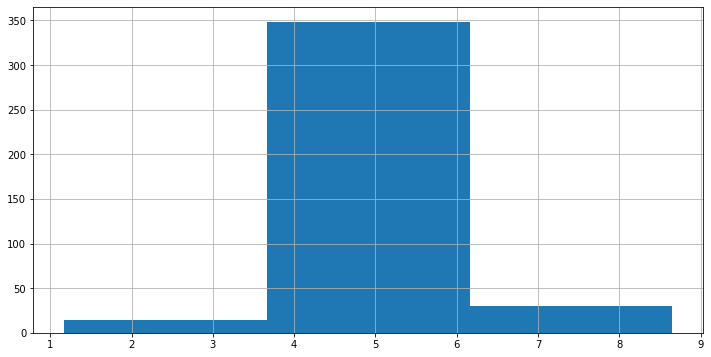

In [11]:
# Check distribution of the predicted values

fig=plt.figure(figsize=(12,6))
predictions_simple_model.predicted_values.hist(bins=3)

In [12]:
# Let's try with the more advanced model with L2 regularization (hard-coded)

def poisson_reg(group):
    
    # Create a pipeline for the Poisson regression model
    
    model = Pipeline([
        ('preprocessor', FunctionTransformer(lambda X: X[['MONTH', 'DAY', 'WEEK']])),
        ('poisson', PoissonRegressor(alpha=1.0, verbose=3))
    ])

    # Fit the Poisson regression model for each unique UPC
    
    X = group[['MONTH', 'DAY', 'WEEK']]
    y = group['y']
    model.fit(X, y)

    # Calculate the null deviance
    y_null = np.ones_like(y) * y.median()
    null_deviance = 2 * np.sum(y * np.log(y / y_null))

#     Set number of periods to forecast

    n_periods = 8
    
    # Generate a date range for the forecast period
    
    start_date = pd.to_datetime(max(group['date']).to_datetime64())
    forecast_dates = pd.date_range(start=start_date + pd.Timedelta(days=7), periods=n_periods, freq='7d')
    
    # Create a dataframe with the predictor variables for the forecast period
    
    forecast_data = pd.DataFrame({
        'MONTH': [date.month for date in forecast_dates],
        'DAY': [date.day for date in forecast_dates],
        'WEEK': [date.week for date in forecast_dates]}, index=forecast_dates)
    predicted_mean = model.predict(forecast_data)

    # Create a dataframe with the predicted values and null deviance
    
    prediction = pd.DataFrame({
        'upc': [group['upc'].iloc[0]] * n_periods,
        'date': forecast_dates,
        'predicted_values': predicted_mean,
        'null_deviance': [null_deviance] * n_periods})
    return prediction


In [13]:
predictions_advanced_model = dataset.groupby('upc').apply(poisson_reg).reset_index(drop=True)


<AxesSubplot:>

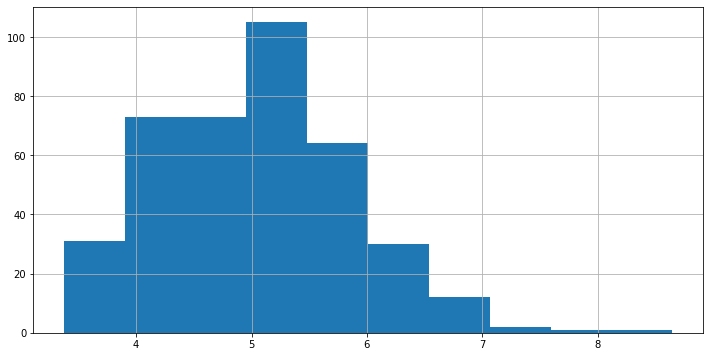

In [14]:
# Check distribution of the predicted values

fig=plt.figure(figsize=(12,6))
predictions_advanced_model.predicted_values.hist()

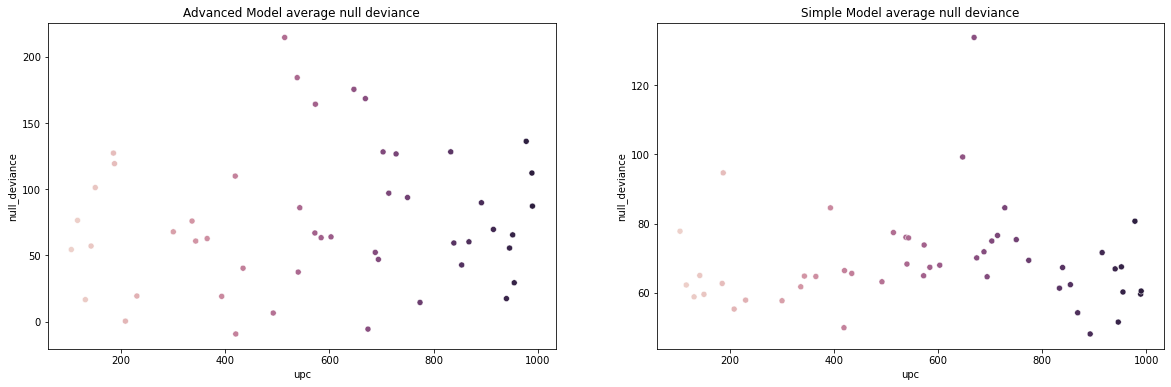

In [15]:
# Check mean null_model deviance using scatterplot for advanced and simple models

# Advanced model

fig, axs = plt.subplots(1, 2, figsize=(20,6))
data1=pd.DataFrame(predictions_advanced_model.groupby('upc')['null_deviance'].mean()).reset_index()
sns.scatterplot(data=data1, x='upc', y='null_deviance', hue='upc', legend=False, ax=axs[0])
axs[0].set_title("Advanced Model average null deviance")

# Simple model

data2=pd.DataFrame(predictions_simple_model.groupby('upc')['null_deviance'].mean()).reset_index()
sns.scatterplot(data=data2, x='upc', y='null_deviance', hue='upc', legend=False, ax=axs[1])
axs[1].set_title("Simple Model average null deviance")

plt.show()


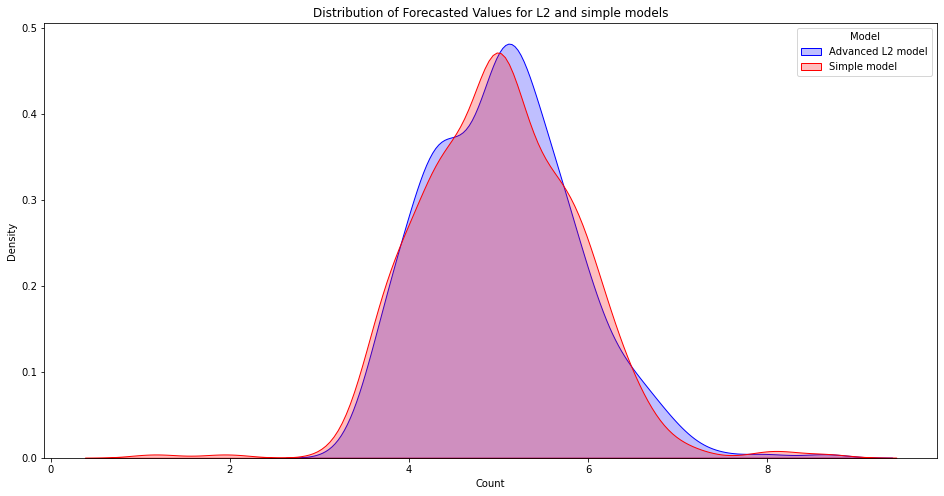

In [16]:
# Create a distribution plots for both models

fig, ax = plt.subplots(figsize=(16, 8))
fig.patch.set_facecolor('white')

# plot the distributions using distplot
sns.distplot(
    predictions_advanced_model['predicted_values'],
    hist=False,
    kde_kws={"shade": True},
    color='blue',
    label='Advanced L2 model',
    ax=ax
)
sns.distplot(
    predictions_simple_model['predicted_values'],
    hist=False,
    kde_kws={"shade": True},
    color='red',
    label='Simple model',
    ax=ax
)

# set the labels and title
ax.set_xlabel('Count')
ax.set_ylabel('Density')
ax.set_title('Distribution of Forecasted Values for L2 and simple models')

# add the legend
ax.legend(title='Model')

plt.show()


In [17]:
# Rename the columns

predictions_simple_model=predictions_simple_model.rename(columns={'predicted_values':'y'})
predictions_advanced_model=predictions_advanced_model.rename(columns={'predicted_values':'y'})

In [18]:
# Merge simple and advanced models to original dataset

merged_simple=pd.concat([predictions_simple_model,dataset],keys=['upc','upc'])
merged_simple = merged_simple.groupby('upc').apply(lambda x: x.sort_values(by='date', ascending=True)).reset_index(drop=True)
merged_simple=merged_simple[['upc','date','y']]

merged_advanced=pd.concat([predictions_advanced_model,dataset],keys=['upc','upc'])
merged_advanced = merged_advanced.groupby('upc').apply(lambda x: x.sort_values(by='date', ascending=True)).reset_index(drop=True)
merged_advanced=merged_advanced[['upc','date','y']]

In [19]:
# Create a flag when forecast startted

predicted = merged_simple.groupby('upc').apply(lambda x: x.iloc[-8:]).reset_index(drop=True)
predicted['predicted'] = 1

for index, row in merged_simple.iterrows():
    if row['date'] in predicted.loc[predicted['upc'] == row['upc'], 'date'].values:
        merged_simple.loc[index, 'predicted'] = 1
    else:
        merged_simple.loc[index, 'predicted'] = 0
        
predicted_adv = merged_advanced.groupby('upc').apply(lambda x: x.iloc[-8:]).reset_index(drop=True)
predicted_adv['predicted'] = 1

for index, row in merged_advanced.iterrows():
    if row['date'] in predicted_adv.loc[predicted_adv['upc'] == row['upc'], 'date'].values:
        merged_advanced.loc[index, 'predicted'] = 1
    else:
        merged_advanced.loc[index, 'predicted'] = 0


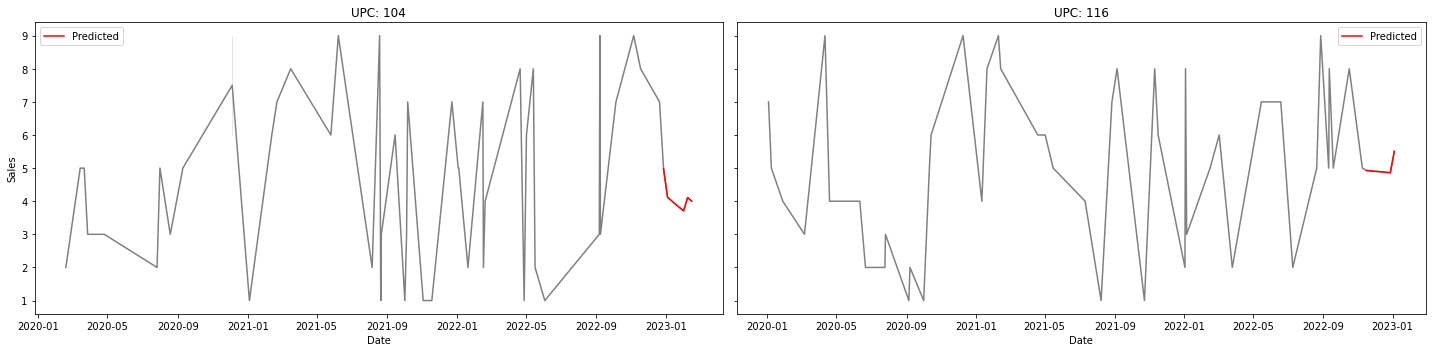

In [20]:
# Plot predicted and accual values for two UPC's - simple model

upcs_to_plot = merged_simple['upc'].unique()[:2]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5), sharey=True)

for i, upc in enumerate(upcs_to_plot):
    subset = merged_simple[merged_simple['upc'] == upc]
    sns.lineplot(x='date', y='y', data=subset, ax=axes[i], color='gray')
    sns.lineplot(x='date', y='y', data=subset[subset['predicted'] == 1], ax=axes[i], color='red', label='Predicted')
    axes[i].set_title(f'UPC: {upc}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Sales')

plt.tight_layout()
plt.show()


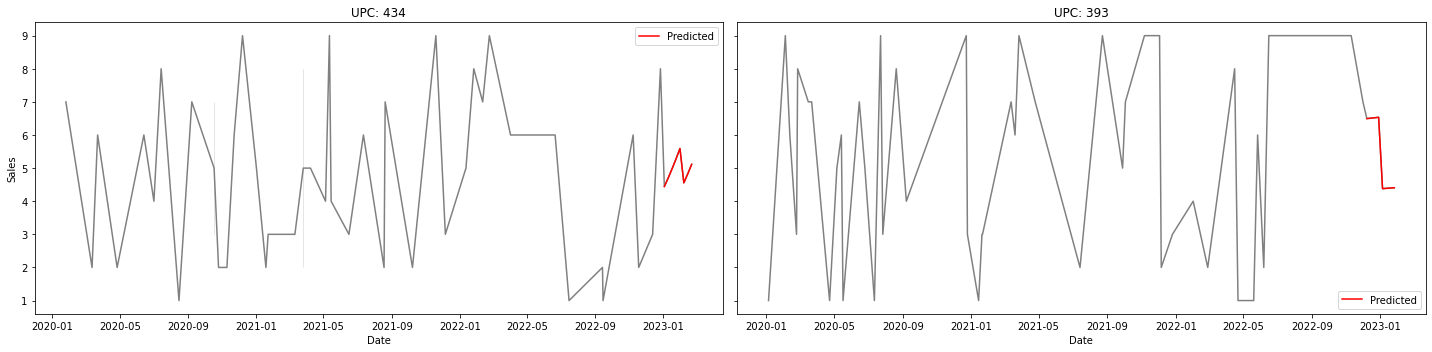

In [21]:
# Plot predicted and accual values for two UPC's - advanced model

upcs_to_plot = merged_advanced['upc'].sample(2).unique()[:2]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5), sharey=True)

for i, upc in enumerate(upcs_to_plot):
    subset = merged_advanced[merged_advanced['upc'] == upc]
    sns.lineplot(x='date', y='y', data=subset, ax=axes[i], color='gray')
    sns.lineplot(x='date', y='y', data=subset[subset['predicted'] == 1], ax=axes[i], color='red', label='Predicted')
    axes[i].set_title(f'UPC: {upc}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Sales')

plt.tight_layout()
plt.show()


In [22]:
# Check the discrepancy between simple and advanced models

Discrepancy=predictions_simple_model.merge(predictions_advanced_model, left_on='upc', right_on='upc')
Discrepancy['diff']=abs(Discrepancy['y_y']-Discrepancy['y_x'])


array([[<AxesSubplot:title={'center':'diff'}>]], dtype=object)

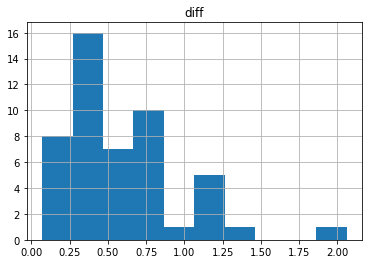

In [24]:
# Check the distibution of the difference between both models
pd.DataFrame(Discrepancy.groupby('upc')['diff'].mean()).sort_values(by='diff',ascending=True).hist()